# Exercices du Tp de Machine Learning

# Exercice 1

Importation des packages 

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot
from sklearn import linear_model

import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import normaltest
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, max_error


Importation de la base

In [2]:
# Définition du répertoire de travail
HOME_DIR = Path.cwd()


DATA_DIR = Path(HOME_DIR, "billets.csv")

print(f"Work directory: {HOME_DIR} \nData directory: {DATA_DIR}")

# importation de la base
data = pd.read_csv(Path(DATA_DIR), sep=";")
data.shape

Work directory: C:\Users\HP\Downloads 
Data directory: C:\Users\HP\Downloads\billets.csv


(1500, 7)

In [ ]:
Création des variables explicatives

In [3]:
data_model = data.loc[lambda dfr: dfr.margin_low.notnull()]
data_model.info()

X = data_model.loc[:, ["diagonal", "height_left", "height_right", "margin_up", "length"]]  # Variable explicatives
y = data_model.loc[:, 'margin_low']

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


In [4]:
X.head()

,diagonal,height_left,height_right,margin_up,length
0,171.81,104.86,104.95,2.89,112.83
1,171.46,103.36,103.66,2.99,113.09
2,172.69,104.48,103.50,2.94,113.16
3,171.36,103.91,103.94,3.01,113.51
4,171.73,104.28,103.46,3.48,112.54


In [5]:
# Séparons nos données en un jeu d'entraînement et un jeu de test :
# 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train set - X: {X_train.shape} ; y: {y_train.shape} \nTest set - X: {X_test.shape} ; y: {y_test.shape}")


Train set - X: (1024, 5) ; y: (1024,) 
Test set - X: (439, 5) ; y: (439,)


# Standardisation

In [6]:
std_scaler = StandardScaler().fit(X_train)  
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

In [10]:
X_train

,diagonal,height_left,height_right,margin_up,length
1243,171.64,104.20,104.10,3.60,112.72
1348,171.84,104.32,104.50,3.00,111.06
137,171.60,104.02,103.90,3.15,113.15
607,171.91,104.17,103.62,2.89,112.73
1198,172.05,104.20,104.11,3.37,111.18
...,...,...,...,...,...
1161,171.92,104.29,104.27,3.13,111.37
1328,172.10,104.22,103.99,3.24,111.94
884,172.57,103.78,103.65,3.04,113.00
1496,172.19,104.63,104.44,3.37,110.97


In [11]:
X_train_std

array([[-1.07074174,  0.5462928 ,  0.54806196,  1.91843401,  0.05088625],
       [-0.40647448,  0.94600971,  1.77308884, -0.68168479, -1.8514336 ],
       [-1.20359519, -0.05328258, -0.06445149, -0.03165509,  0.54365585],
       ...,
       [ 2.01810103, -0.85271641, -0.83009329, -0.50834354,  0.37175948],
       [ 0.75599323,  1.97861174,  1.58933481,  0.9217218 , -1.95457142],
       [ 0.4238596 , -1.11919435,  1.06869838,  1.52841619, -0.54502117]])

In [12]:
X_test_std

array([[-0.00791412,  1.14586817, -0.30945687,  0.70504524, -1.14092859],
       [-0.57254129,  1.77875329,  0.36430792, -0.03165509,  0.89890835],
       [ 0.09172597, -0.45299949,  0.88494435, -0.3783376 ,  0.38321924],
       ...,
       [ 0.98848677, -0.51961898,  0.70119032, -0.76835542,  0.64679367],
       [ 0.09172597,  0.27981485,  0.79306733, -1.76506763,  0.57803512],
       [ 1.38704713, -1.6188405 , -0.37070821, -1.11503793,  0.71555222]])

In [ ]:
Définition de la fonction train_model

In [7]:
def train_model(model, x_train, y_train, x_test, y_test):
    # On entraîne ce modèle sur les données d'entrainement
    model.fit(x_train, y_train)
    
    # On récupère l'erreur de norme 2 sur le jeu de données train
    mse_train = np.mean((model.predict(x_train) - y_train) ** 2)

    # On récupère l'erreur de norme 2 sur le jeu de données test
    mse_test = np.mean((model.predict(x_test) - y_test) ** 2)

    # On obtient l'erreur quadratique ci-dessous
    print(f"Model error: {round( mse_test, 5)}")
    return {"estimator": model, " mse_train":  mse_train, "mse_test": mse_test}

In [9]:
elastic_mse = train_model(model=linear_model.ElasticNet(fit_intercept=True, alpha=1., l1_ratio=.5),
                            x_train=X_train_std, y_train=y_train,
                            x_test=X_test_std, y_test=y_test)

Model error: 0.42698


In [ ]:
Analyse des variables explicatives pour les données train

In [11]:
from sklearn.linear_model import ElasticNet

# Créer et entraîner le modèle Elastic Net
model=linear_model.ElasticNet(fit_intercept=True, alpha=1., l1_ratio=.5)
# entrainement du modèle
model.fit(X_train_std, y_train)
# Extraire les coefficients
coefficients = model.coef_

# Afficher les coefficients avec le nom des variables (si les noms sont disponibles)
import pandas as pd

# Créer un DataFrame pour associer chaque variable à son coefficient
coef_df = pd.DataFrame({
    'Variable': X_train_std.columns if hasattr(X_train_std, 'columns') else range(len(coefficients)),
    'Coefficient': coefficients
})

print(coef_df)


   Variable  Coefficient
0         0         -0.0
1         1          0.0
2         2          0.0
3         3          0.0
4         4         -0.0


In [ ]:
Analyse des variables explicatives pour les données test

pour les données train on retient que: 

Coefficients Nulls : Tous les coefficients sont soit 0.0, soit très proches de 0.0. Cela suggère que le modèle n'a pas trouvé de relations significatives entre les variables d'entrée et la variable cible. Les coefficients proches de zéro indiquent que ces variables n'ont pas d'impact significatif sur la prédiction.

Régularisation : Étant donné que le modèle utilise une régularisation (Elastic Net), il est possible que les coefficients aient été pénalisés pour éviter le surajustement. Cependant, dans ce cas, il semble que la régularisation ait conduit à des coefficients très faibles ou nuls.

Performance du Modèle : Les coefficients proches de zéro peuvent indiquer que le modèle n'est pas performant sur ce jeu de données particulier. Il pourrait être nécessaire de réévaluer les données, d'ajuster les hyperparamètres du modèle, ou d'explorer d'autres modèles ou techniques de pré-traitement.

In [12]:
# Créer et entraîner le modèle Elastic Net
model=linear_model.ElasticNet(fit_intercept=True, alpha=1., l1_ratio=.5)
# entrainement du modèle
model.fit(X_test_std, y_test)
# Extraire les coefficients
coefficients = model.coef_

# Afficher les coefficients avec le nom des variables (si les noms sont disponibles)
import pandas as pd

# Créer un DataFrame pour associer chaque variable à son coefficient
coef_df = pd.DataFrame({
    'Variable': X_train_std.columns if hasattr(X_train_std, 'columns') else range(len(coefficients)),
    'Coefficient': coefficients
})

print(coef_df)

   Variable  Coefficient
0         0         -0.0
1         1          0.0
2         2          0.0
3         3          0.0
4         4         -0.0



Après entraînement on n'obtient pzs un grzand changement des données. en effet :
Coefficients Nulls : Tous les coefficients sont soit 0.0, soit très proches de 0.0. Cela suggère que le modèle n'a pas trouvé de relations significatives entre les variables d'entrée et la variable cible. Les coefficients proches de zéro indiquent que ces variables n'ont pas d'impact significatif sur la prédiction.

Régularisation : Étant donné que le modèle utilise une régularisation (Elastic Net), il est possible que les coefficients aient été pénalisés pour éviter le surajustement. Cependant, dans ce cas, il semble que la régularisation ait conduit à des coefficients très faibles ou nuls.

Performance du Modèle : Les coefficients proches de zéro peuvent indiquer que le modèle n'est pas performant sur ce jeu de données particulier. Il pourrait être nécessaire de réévaluer les données, d'ajuster les hyperparamètres du modèle, ou d'explorer d'autres modèles ou techniques de pré-traitement.

# Analyse des variables

# Interprétation des Résultats du Modèle Elastic Net

D'après les résultats obtenus ci-dessus, les coefficients des variables explicatives sont quasi-nuls tant sur les données d'entraînement que sur les données de test. Les variables "diagonal" et "length" présentent des coefficients négatifs, mais très proches de zéro. Les autres variables, telles que "height_left", "height_right" et "margin_up", ont toutes des coefficients nuls. En valeur absolue, aucune variable n'a été identifiée comme importante pour la modélisation. Cela peut être dû à plusieurs raisons :

## Raisons Possibles

1. **Non-corrélation entre la variable cible et les variables explicatives** :
   - Il est possible qu'il n'y ait pas de corrélation significative entre la variable cible et les variables explicatives.

2. **Alpha trop élevé** :
   - Un alpha trop élevé (la force de la régularisation) peut entraîner des coefficients nuls, car il impose une pénalisation excessive sur les coefficients, les forçant vers zéro.

3. **L1_ratio trop élevé** :
   - Un l1_ratio trop élevé (proche de 1) signifie que la pénalité L1 (Lasso) domine le modèle. Cela peut forcer les coefficients des variables à zéro, surtout si certaines variables sont fortement corrélées.

Ces facteurs peuvent expliquer pourquoi les coefficients des variables explicatives sont quasi-nuls, rendant difficile l'identification de variables importantes pour la modélisation.

## Conclusion

Les résultats montrent que le modèle Elastic Net n'a pas trouvé de relations significatives entre les variables d'entrée et la variable cible dans ce jeu de données. Les coefficients proches de zéro suggèrent une faible ou aucune influence des variables sur la prédiction. Des ajustements supplémentaires ou une exploration de différents modèles peuvent être nécessaires pour améliorer la performance du modèle.


# Exercice 2

# Optimisation du modèle Ridge

In [37]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error

# Liste des valeurs de alpha à tester
alphas =  [0.001,0.01, 0.1, 1, 10, 100]
# Modèle Ridge avec optimisation de alpha
ridge_cv = RidgeCV(alphas=alphas, cv=5)  # cv=5 pour la validation croisée
ridge_cv.fit(X_train, y_train)
ridge_predictions = ridge_cv.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("Best alpha for Ridge:", ridge_cv.alpha_)
print("Ridge MSE:", ridge_mse)






Best alpha for Ridge: 10.0
Ridge MSE: 0.21612728031473544


Durésultat ci-dessus on note que 
Optimisation de alpha : La valeur de alpha optimale pour le modèle Ridge est 10.0, ce qui indique que cette valeur de régularisation a permis d'obtenir les meilleures performances lors de la validation croisée.
Performance du Modèle : L'erreur quadratique moyenne (MSE) de 0.216 montre que le modèle Ridge a une certaine précision sur les données de test, bien que cette valeur puisse être améliorée.

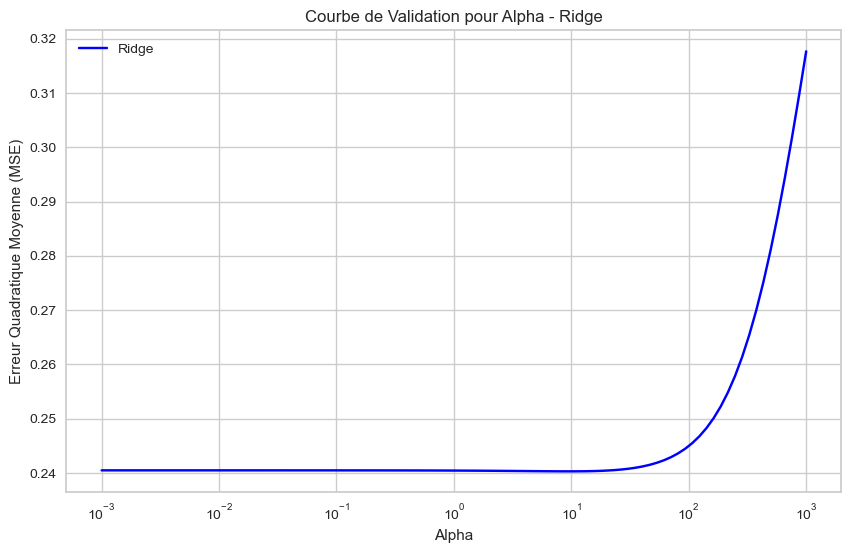

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Définir une plage de valeurs pour alpha
alphas = np.logspace(-3, 3, 100)  # de 0.001 à 100
ridge_mse_path = []

# Boucle pour calculer la MSE en validation croisée pour chaque alpha
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    # On prend la moyenne des scores de validation croisée en 5-fold (5 plis)
    mse = -cross_val_score(ridge, X_train, y_train, scoring="neg_mean_squared_error", cv=5).mean()
    ridge_mse_path.append(mse)

# Tracer la courbe de MSE en fonction d'alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, ridge_mse_path, label="Ridge", color="blue")
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("Erreur Quadratique Moyenne (MSE)")
plt.title("Courbe de Validation pour Alpha - Ridge")
plt.legend()
plt.grid(True)
plt.show()


La courbe de validation pour le modèle Ridge montre l'évolution de l'erreur quadratique moyenne (MSE) en fonction des différentes valeurs de l'hyperparamètre alpha. On observe que pour des valeurs d'alpha très faibles, la MSE reste relativement stable et basse, indiquant une bonne performance du modèle. Cependant, à mesure que la valeur d'alpha augmente, la MSE commence à augmenter de manière significative, ce qui suggère un surajustement du modèle. Enfin, pour les valeurs d'alpha très élevées, la MSE devient très élevée, indiquant une perte de performance du modèle.

# optimisation du modèle Lasso

In [36]:
# Liste des valeurs de alpha à tester
alphas = [0.001,0.01, 0.1, 1, 10, 100]
# Modèle Lasso avec optimisation de alpha
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train_std, y_train)
lasso_predictions = lasso_cv.predict(X_test_std)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("Best alpha for Lasso:", lasso_cv.alpha_)
print("Lasso MSE:", lasso_mse)

Best alpha for Lasso: 0.001
Lasso MSE: 0.21627845861718403


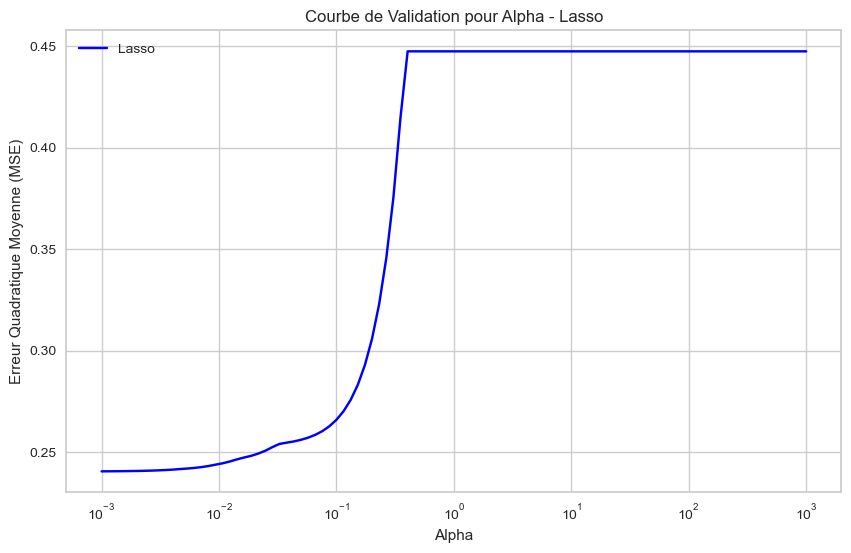

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Définir une plage de valeurs pour alpha
alphas = np.logspace(-3, 3, 100)  # de 0.001 à 100
lasso_mse_path = []

# Boucle pour calculer la MSE en validation croisée pour chaque alpha
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    # On prend la moyenne des scores de validation croisée en 5-fold (5 plis)
    mse = -cross_val_score(lasso, X_train, y_train, scoring="neg_mean_squared_error", cv=5).mean()
    lasso_mse_path.append(mse)

# Tracer la courbe de MSE en fonction d'alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, lasso_mse_path, label="Lasso", color="blue")
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("Erreur Quadratique Moyenne (MSE)")
plt.title("Courbe de Validation pour Alpha - Lasso")
plt.legend()
plt.grid(True)
plt.show()


La courbe de validation des alphas pour le modèle Lasso montre l'évolution de l'erreur quadratique moyenne (MSE) en fonction des différentes valeurs de l'hyperparamètre alpha. On observe que les valeurs d'alpha inférieures à 0.001 minimisent l'erreur quadratique moyenne, atteignant une valeur d'environ 0.22. Cela indique que pour ces valeurs d'alpha, le modèle Lasso parvient à un bon ajustement des données.

Pour des valeurs d'alpha comprises entre 0.001 et environ 0.1, l'erreur quadratique moyenne reste relativement stable et basse, ce qui suggère que le modèle conserve une bonne performance. Cependant, au-delà de 0.1, l'erreur quadratique moyenne commence à augmenter de manière significative, indiquant un surajustement du modèle.

# Optimisation du modèle Elastic_net

In [39]:
# Liste des valeurs de alpha à tester
alphas = [0.001,0.01, 0.1, 1, 10, 100]
# Modèle Elastic Net avec optimisation de alpha et l1_ratio
elastic_net_cv = ElasticNetCV(alphas=alphas, l1_ratio=[0.1, 0.5, 0.9], cv=5)
elastic_net_cv.fit(X_train_std, y_train)
elastic_net_predictions = elastic_net_cv.predict(X_test_std)
elastic_net_mse = mean_squared_error(y_test, elastic_net_predictions)
print("Best alpha for Elastic Net:", elastic_net_cv.alpha_)
print("Best l1_ratio for Elastic Net:", elastic_net_cv.l1_ratio_)
print("Elastic Net MSE:", elastic_net_mse)

Best alpha for Elastic Net: 0.01
Best l1_ratio for Elastic Net: 0.1
Elastic Net MSE: 0.2163614011364333


# Importance des variables

       Variable  Ridge Coefficients  Lasso Coefficients  \
0      diagonal           -0.080331           -0.025509   
1   height_left            0.167500            0.052383   
2  height_right            0.244682            0.084430   
3     margin_up            0.244855            0.066037   
4        length           -0.409318           -0.353119   

   ElasticNet Coefficients  
0                -0.025524  
1                 0.052807  
2                 0.084761  
3                 0.067437  
4                -0.348963  


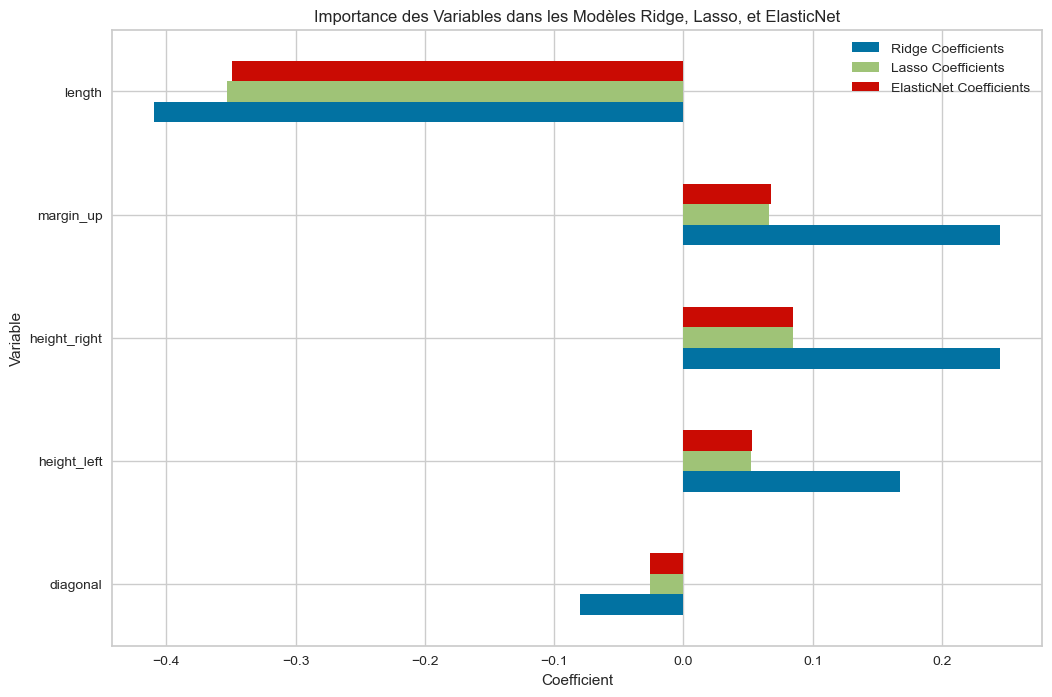

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraire les coefficients pour chaque modèle
coef_df = pd.DataFrame({
    'Variable': X_train.columns if hasattr(X_train, 'columns') else range(len(ridge_cv.coef_)),
    'Ridge Coefficients': ridge_cv.coef_,
    'Lasso Coefficients': lasso_cv.coef_,
    'ElasticNet Coefficients': elastic_net_cv.coef_
})

# Afficher les coefficients pour chaque modèle
print(coef_df)

# Visualisation de l'importance des coefficients pour chaque modèle
coef_df.set_index('Variable').plot(kind='barh', figsize=(12, 8))
plt.title("Importance des Variables dans les Modèles Ridge, Lasso, et ElasticNet")
plt.xlabel("Coefficient")
plt.show()


# Analyse des Coefficients des Modèles Ridge, Lasso et Elastic Net

En examinant les coefficients des modèles Ridge, Lasso et Elastic Net, nous constatons que la variable "length" est la plus influente. Elle présente les coefficients les plus élevés en valeur absolue dans tous les modèles, avec un impact négatif sur la cible. Cela signifie que la variable "length" contribue fortement et de manière négative à la prédiction.

La variable "height_right" est également importante, avec des coefficients positifs relativement élevés dans les trois modèles. Cela indique qu'elle influence positivement la cible. Les variables "height_left" et "margin_up" jouent un rôle modéré, avec des valeurs de coefficients positives mais moins significatives. Enfin, la variable "diagonal" a peu d'impact, avec des coefficients proches de zéro, ce qui pourrait indiquer une contribution négligeable au modèle.

## Interprétation des Résultats

- **Variable "length"** : La variable "length" est la plus influente, avec des coefficients négatifs élevés dans tous les modèles. Cela suggère qu'une longueur plus importante est associée à une diminution de la cible prédite.
- **Variable "height_right"** : La variable "height_right" a des coefficients positifs relativement élevés, indiquant une influence positive sur la cible. Une hauteur droite plus élevée est donc associée à une augmentation de la cible prédite.
- **Variables "height_left" et "margin_up"** : Ces variables jouent un rôle modéré avec des coefficients positifs, mais moins significatifs. Elles ont un impact modéré sur la prédiction.
- **Variable "diagonal"** : La variable "diagonal" a peu d'impact, avec des coefficients proches de zéro, ce qui suggère une contribution négligeable au modèle.


en conclusion, Les résultats montrent que certaines variables, telles que "length" et "height_right", ont un impact significatif sur la prédiction, tandis que d'autres, comme "diagonal", ont peu d'influence. Cette analyse permet de mieux comprendre les contributions relatives des variables et d'optimiser les modèles pour améliorer leur performance prédictive.


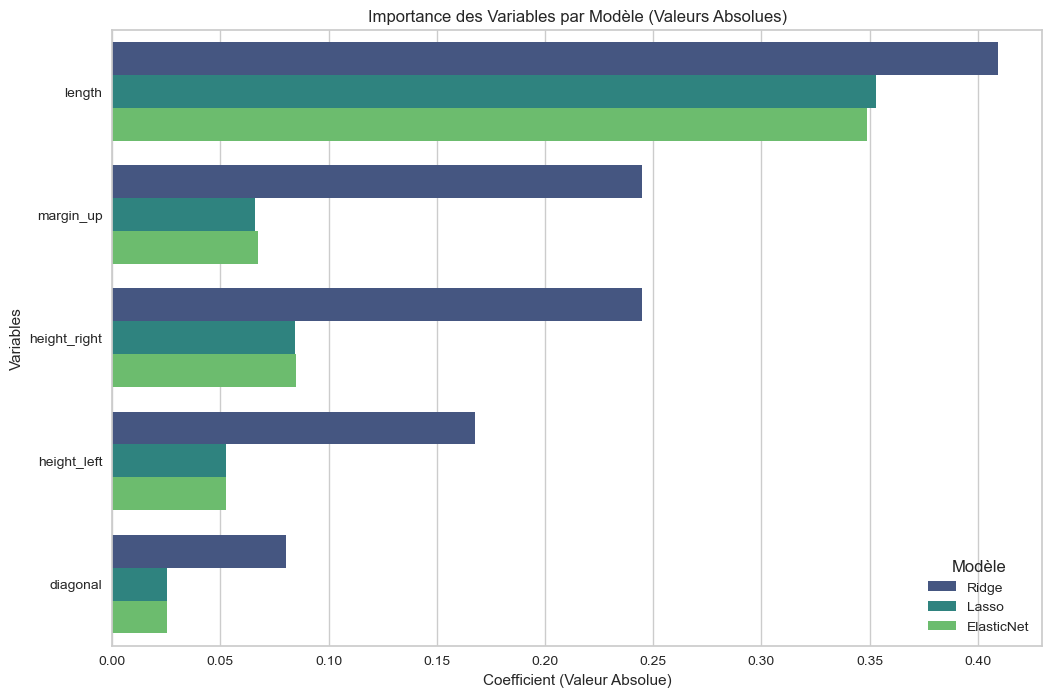

In [42]:
import numpy as np
import pandas as pd

# Extraire les coefficients en valeurs absolues pour chaque modèle
coef_df = pd.DataFrame({
    'Variable': X_train.columns if hasattr(X_train, 'columns') else range(len(ridge_cv.coef_)),
    'Ridge': np.abs(ridge_cv.coef_),
    'Lasso': np.abs(lasso_cv.coef_),
    'ElasticNet': np.abs(elastic_net_cv.coef_)
})

import seaborn as sns
import matplotlib.pyplot as plt

# Transformation du DataFrame pour un graphique Seaborn (melt)
coef_df_melted = coef_df.melt(id_vars="Variable", var_name="Modèle", value_name="Coefficient")

# Tri des variables par importance moyenne
coef_df_melted["Importance"] = coef_df_melted["Coefficient"]
coef_df_melted = coef_df_melted.sort_values(by="Importance", ascending=False)

# Création du graphique en barres
plt.figure(figsize=(12, 8))
sns.barplot(data=coef_df_melted, x="Coefficient", y="Variable", hue="Modèle", palette="viridis")
plt.title("Importance des Variables par Modèle (Valeurs Absolues)")
plt.xlabel("Coefficient (Valeur Absolue)")
plt.ylabel("Variables")
plt.legend(title="Modèle")
plt.show()


## Importance Relative

- **Length** : La variable "length" a la plus grande importance dans tous les modèles.

- **Height_right et Margin_up** : Ces variables viennent après "length" en termes d'importance dans les trois modèles.

- **Diagonal** : La variable "diagonal" a la plus faible importance.

## Comparaison des Modèles

Le graphique montre comment l'importance des variables varie entre les modèles. Ridge, Lasso, et ElasticNet attribuent une importance similaire à certaines variables clés, mais il peut y avoir des différences subtiles dans les valeurs des coefficients.